#Introduction
In many Machine Learning (ML) communities, I have observed that many people are often struggling with different problems which are actually rooted on the exact same problem. The main issue is not “how to perform this step?” but rather than “which step should be performed first?”. In addition, the existing tutorials and articles mostly cover different techniques to perform a specific step (for e.g., how to deal with imbalance class or skewed continuous features). Therefore, I proposed a template that provides a general workflow to guide the process of developing ML models for classification and regression tasks on tabular data in the Kaggle Competition setting. To my knowledge, this is the first notebook that is dedicated to establish the exact same workflow for various ML tasks.







---


>  Enjoy your journey. Explore sufficiently, stop when you are tired. Do not aim for a perfect model, decent one is enough.


---

Click on the `Table of contents` menu_icon_resized.png menu_icon.png icon on the top left toolbar to view the outline of overall steps.

TO-DO LIST

---


List of experiments :

1. upsampling **[off]**
2. one-hot `Pclass` **[off]**
3. log transformation on `Fare` feature **[off]**
4. impute outlier with median. **[off]**


Or 


Permutation approach

==== Permutate with 2<sup>4</sup> number of permutation if possible ==== 

1. [on, on, on, on]
2. [on, off, on, on]
3. [on, on, off, on] 

*As the **baseline** is obtained it's important to plan ahead the list of experiments to improve the baseline rather than mindlessly trying different approaches over and over again. With a plan before hand, it helps us track what have been done and what haven't.* 




## step 1 : install all dependencies

In [ ]:
!pip install catboost

## step 2 : import all libraries

In [ ]:
import pandas as pd
import numpy as np 
import seaborn as sns
import missingno
import matplotlib.pyplot as plt

from collections import Counter
from numpy import percentile
from typing import Dict

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import precision_recall_fscore_support as scorer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

## step 2 : store any utility function here.

In [ ]:
def extract_missing_values_col_names(df):
  missing_val_col_names = []
  for col in tqdm(df.columns):
    if(df[col].isnull().any()):
      missing_val_col_names.append(col)

  return missing_val_col_names

def eval_train_test(model, X_train, X_test, y_train, y_test, plot_auc = False):
  train_predictions = model.predict(X_train)
  test_predictions = model.predict(X_test)

  prec_train, rec_train, f1_train, sup_train = scorer(y_train, train_predictions, average = 'macro')
  prec_test, rec_test, f1_test, sup_test = scorer(y_test, test_predictions, average = 'macro')
  
  data = {'train': [prec_train, rec_train, f1_train, sup_train], 
           'test': [prec_test, rec_test, f1_test, sup_test]}

  df = pd.DataFrame.from_dict(data, orient='index',
                      columns=['precision', 'recall', 'f1', 'support'])
 
  return df 

def extract_multicolin_features(df, threshold = 0.75, plot = False):
  correlation_matrix = df.corr()

  if plot:
    plt.figure(figsize = (12, 10))
    sns.heatmap(correlation_matrix, annot = True, cmap="Greens")
    plt.show()
  
  highly_correlated_features = []
  
  for col_name, each_column in correlation_matrix.items():  
    
    for row_name, corr_value in each_column.items():                
      if col_name != row_name:      
        if abs(corr_value) >= threshold:
          highly_correlated_features.append(row_name)           
    
  return [*Counter(highly_correlated_features)], correlation_matrix


def identify_and_extract_outlier_indices_with_iqr(df, drop_outliers = False, impute_with_median = False):
  outlier_sample_indices = []

  for feature_idx, feature_name in enumerate(df.columns):
    feature_distribution = df[feature_name]
    
    # calculate interquartile range
    q25, q75 = percentile(feature_distribution, 25), percentile(feature_distribution, 75)  
    iqr = q75 - q25
    # calculate the outlier cutoff
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off  
      
    # identify outliers
    num_of_outlier = 0
    for sample_idx, sample_val in enumerate(feature_distribution):
      # if indices hasn't been added yet 
      if sample_val < lower or sample_val > upper:
        num_of_outlier += 1

        # if impute with median
        if impute_with_median:
          # step 1 : calculate the median of that particular feature
          median = df[feature_name].median()
          # step 2 : impute the outlier with the median 
          df[feature_name][sample_idx] = median

        if sample_idx not in outlier_sample_indices:
          outlier_sample_indices.append(sample_idx)
    print(f"> feature [{feature_name}] has `{num_of_outlier}` outliers")
  
  print()
  print(f"Total outlier samples = {len(outlier_sample_indices)}")

  if drop_outliers and (impute_with_median is False):
    df.drop(df.index[outlier_sample_indices], inplace = True)

  return df

## step 3 : load the dataset

In [ ]:
train_path = '/content/train.csv'
train_data = pd.read_csv(train_path)
print(train_data.shape)

test_path = '/content/test.csv'
test_data = pd.read_csv(test_path)
print(test_data.shape)

(891, 12)
(418, 11)


## step 4 : take a peek on the subset of data

In [ ]:
train_data.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
test_data.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## step 5 : show data description

In [ ]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## step 7 : drop useless features

What is considered as useless features?

> Well, there are no exact rules for a feature to be determined as useless. One way to identify useless features could be by reading through the "features description" (if provided) and compare the relevancy with the changes in target variable. This is done by simply using our common sense, nothing fancy. For example, in the case of Titanic ML competition, the features such as "passenger name" and "ticket number" might not be relevant to determine whether the passengers will survive or not from the Titanic shipwreck. Hence, we could try to drop these features.


In [ ]:
train_data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis = 1, inplace = True)
test_data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis = 1, inplace = True)

In [ ]:
train_data.head(5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,2.110213,S
1,1,1,female,38.0,1,0,4.280593,C
2,1,3,female,26.0,0,0,2.188856,S
3,1,1,female,35.0,1,0,3.990834,S
4,0,3,male,35.0,0,0,2.202765,S


In [ ]:
test_data.head(5)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q
3,3,male,27.0,0,0,8.6625,S
4,3,female,22.0,1,1,12.2875,S


## step 8 : categorical features encoding (optional)

#### step 8.1 : one-hot encoding

for train set

In [ ]:
# step 1 : perform one-hot encoding to the column/columns
one_hot_embarked = pd.get_dummies(train_data.Embarked, prefix='Embarked')

# step 2 : concat to the dataset
train_data = pd.concat([train_data, one_hot_embarked], axis = 1)

# step 3 : drop the original column/columns
train_data.drop(['Embarked'], axis = 1, inplace = True)
train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
0,0,3,male,22.0,1,0,7.2500,0,0,1
1,1,1,female,38.0,1,0,71.2833,1,0,0
2,1,3,female,26.0,0,0,7.9250,0,0,1
3,1,1,female,35.0,1,0,53.1000,0,0,1
4,0,3,male,35.0,0,0,8.0500,0,0,1


In [ ]:
# step 1 : perform one-hot encoding to the column/columns
one_hot_pclass = pd.get_dummies(train_data.Pclass, prefix='Pclass')

# step 2 : concat to the dataset
train_data = pd.concat([train_data, one_hot_pclass], axis = 1)

# step 3 : drop the original column/columns
train_data.drop(['Pclass'], axis = 1, inplace = True)
train_data.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,0,male,22.0,1,0,7.2500,0,0,1,0,0,1
1,1,female,38.0,1,0,71.2833,1,0,0,1,0,0
2,1,female,26.0,0,0,7.9250,0,0,1,0,0,1
3,1,female,35.0,1,0,53.1000,0,0,1,1,0,0
4,0,male,35.0,0,0,8.0500,0,0,1,0,0,1


for test set

In [ ]:
# step 1 : perform one-hot encoding to the column/columns
one_hot_embarked = pd.get_dummies(test_data.Embarked, prefix='Embarked')

# step 2 : concat to the dataset
test_data = pd.concat([test_data, one_hot_embarked], axis = 1)

# step 3 : drop the original column/columns
test_data.drop(['Embarked'], axis = 1, inplace = True)
test_data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
0,3,male,34.5,0,0,7.8292,0,1,0
1,3,female,47.0,1,0,7.0000,0,0,1
2,2,male,62.0,0,0,9.6875,0,1,0
3,3,male,27.0,0,0,8.6625,0,0,1
4,3,female,22.0,1,1,12.2875,0,0,1


In [ ]:
# step 1 : perform one-hot encoding to the column/columns
one_hot_pclass = pd.get_dummies(test_data.Pclass, prefix='Pclass')

# step 2 : concat to the dataset
test_data = pd.concat([test_data, one_hot_pclass], axis = 1)

# step 3 : drop the original column/columns
test_data.drop(['Pclass'], axis = 1, inplace = True)
test_data.head()

,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,male,34.5,0,0,7.8292,0,1,0,0,0,1
1,female,47.0,1,0,7.0000,0,0,1,0,0,1
2,male,62.0,0,0,9.6875,0,1,0,0,1,0
3,male,27.0,0,0,8.6625,0,0,1,0,0,1
4,female,22.0,1,1,12.2875,0,0,1,0,0,1


#### step 8.2 : label encoding

In [ ]:
from sklearn import preprocessing 

label_encoder = preprocessing.LabelEncoder() 

For train set

In [ ]:
train_data['Sex'] = label_encoder.fit_transform(train_data['Sex']) 
train_data.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,0,1,22.0,1,0,2.110213,0,0,1,0,0,1
1,1,0,38.0,1,0,4.280593,1,0,0,1,0,0
2,1,0,26.0,0,0,2.188856,0,0,1,0,0,1
3,1,0,35.0,1,0,3.990834,0,0,1,1,0,0
4,0,1,35.0,0,0,2.202765,0,0,1,0,0,1


For test set

In [ ]:
test_data['Sex'] = label_encoder.fit_transform(test_data['Sex']) 
train_data.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,0,1,22.0,1,0,2.110213,0,0,1,0,0,1
1,1,0,38.0,1,0,4.280593,1,0,0,1,0,0
2,1,0,26.0,0,0,2.188856,0,0,1,0,0,1
3,1,0,35.0,1,0,3.990834,0,0,1,1,0,0
4,0,1,35.0,0,0,2.202765,0,0,1,0,0,1


## step 9 : split train data



---


The goal of splitting data is to generate 3 partition for the purpose of model development. The partition consist of:

*   Train set : used to train the model
*   Validation set : used to validate the trained model
*   Test set : used to test the final model



---

To split the data, </br>
1. If you have **a single file**, then: 
  *   First, split into 2 partition : (a) ~70% for **train** and (b) ~30% for **test**.
  *   Second, takes the **train set** from the previous splitted partition and split it again into another 2 partition with the same ratio : (a) ~70% for **train** and (b) ~30% for **validation**.

2. If you have **two files** (train, test), then:
  * Split the **train set** into 2 partition : (a) ~70% for **train** and (b) ~30% for **test**.
  
3. If you have **three files** (train, val, test), then:
  * You are good to go.



In [ ]:
from sklearn.model_selection import train_test_split as data_splitter

train_data, val_data = data_splitter(train_data, 
                                    test_size = 0.2,
                                    random_state = 42)

## step 10 : normalize data 

*It is important to note that, data normalization or standardization step has to be performed after the process of data splitting. This is to prevent information leaking between each data partition.*


In [ ]:
from sklearn.preprocessing import MinMaxScaler
cols_to_norm = ['Age','Fare']

for train data

In [ ]:
train_data[cols_to_norm] = MinMaxScaler().fit_transform(train_data[cols_to_norm])

In [ ]:
train_data.head(5)

,Survived,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
331,0,1,0.566474,0,0,0.542291,0,0,1,1,0,0
733,0,1,0.283740,0,0,0.422864,0,0,1,0,1,0
382,0,1,0.396833,0,0,0.350727,0,0,1,0,0,1
704,0,1,0.321438,1,0,0.349451,0,0,1,0,0,1
813,0,0,0.070118,4,2,0.556696,0,0,1,0,0,1


for validation data

In [ ]:
val_data[cols_to_norm] = MinMaxScaler().fit_transform(val_data[cols_to_norm])

In [ ]:
val_data.head(5)

,Survived,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
709,1,1,NaN,1,1,0.500187,1,0,0,0,0,1
439,0,1,0.429956,0,0,0.438201,0,0,1,0,1,0
840,0,1,0.273194,0,0,0.392720,0,0,1,0,0,1
720,1,0,0.073678,0,1,0.632692,0,0,1,0,1,0
39,1,0,0.187687,1,0,0.449415,1,0,0,0,0,1


In [ ]:
test_data[cols_to_norm] = MinMaxScaler().fit_transform(test_data[cols_to_norm])

In [ ]:
test_data.head(5)

,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,1,0.452723,0,0,0.015282,0,1,0,0,0,1
1,0,0.617566,1,0,0.013663,0,0,1,0,0,1
2,1,0.815377,0,0,0.018909,0,1,0,0,1,0
3,1,0.353818,0,0,0.016908,0,0,1,0,0,1
4,0,0.287881,1,1,0.023984,0,0,1,0,0,1


## step 11 : features visualization

### step 11.1 : identify outliers


#### option 1 : visualize outlier with boxplot

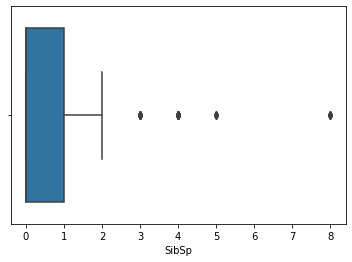

In [ ]:
sns.boxplot(x = train_data['SibSp'])

#### option 2 : describe outlier numerically using IQR (InterQuartile Range)

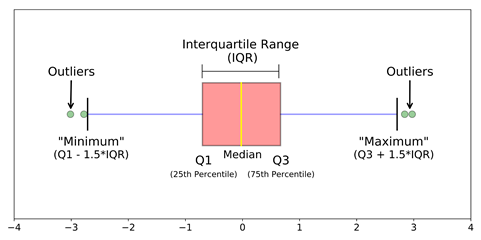

In [ ]:
# _ = identify_and_extract_outlier_indices_with_iqr(train_data)  

#### 11.1.1 : deal with outliers

##### Option 1 : Median imputation
Why **median** and not **mean**? 

> As the mean value is highly influenced by the outliers, it is advised to replace the outliers with the median value. (reference : [analytics vidhya](https://www.analyticsvidhya.com/blog/2021/05/detecting-and-treating-outliers-treating-the-odd-one-out/)). In addition, this is also the reason why we deal with outlier first before handling missing values as the mean often used to impute them.

In [ ]:
# train_data = identify_and_extract_outlier_indices_with_iqr(train_data, impute_with_median = True)  

##### Option 1 : Drop outlier sample

In [ ]:
# train_data.drop(train_data.index[outlier_sample_indices], inplace=True)

### step 11.2 : visualize missing values

**for train data**

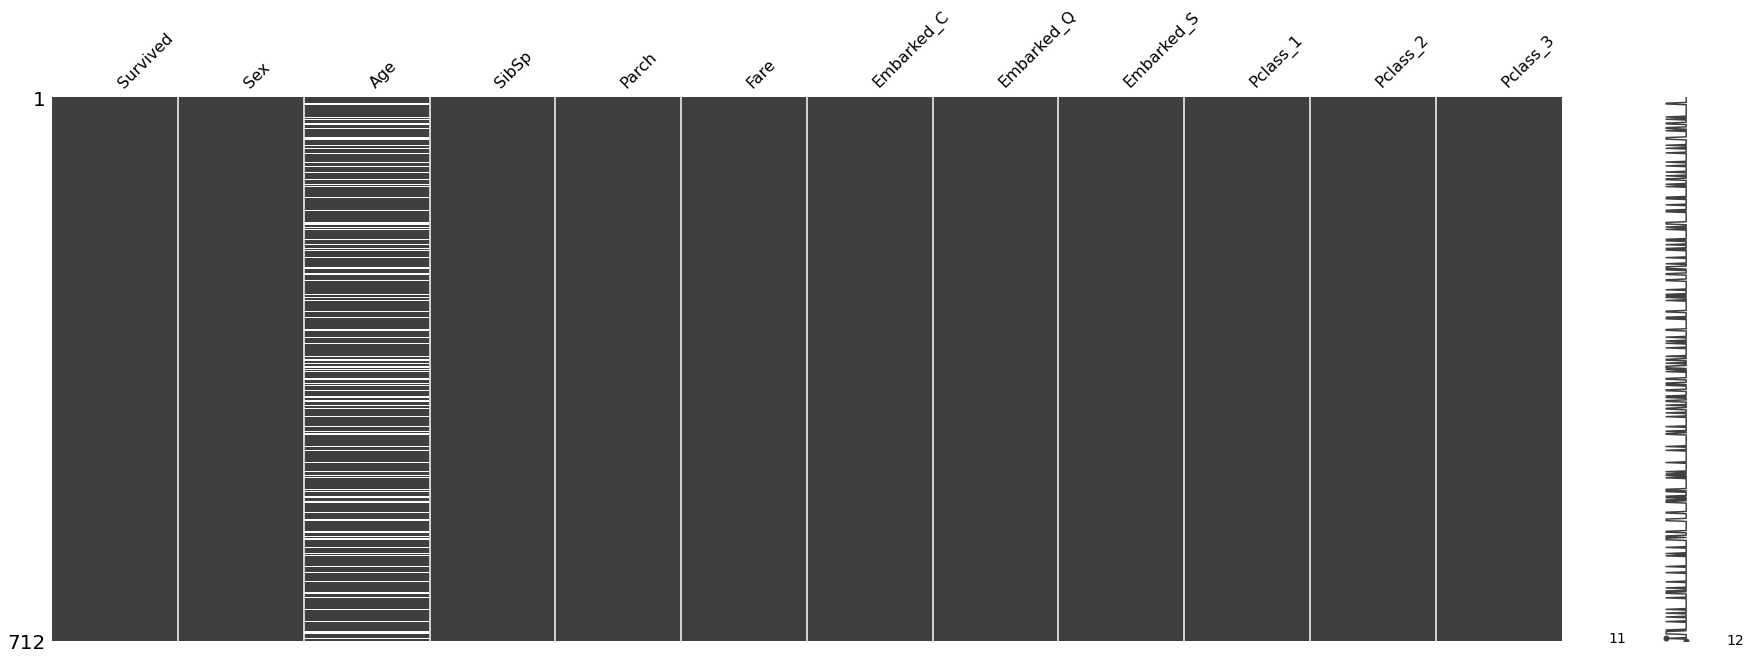

In [ ]:
missingno.matrix(train_data, figsize = (30,10))

**for validation data**

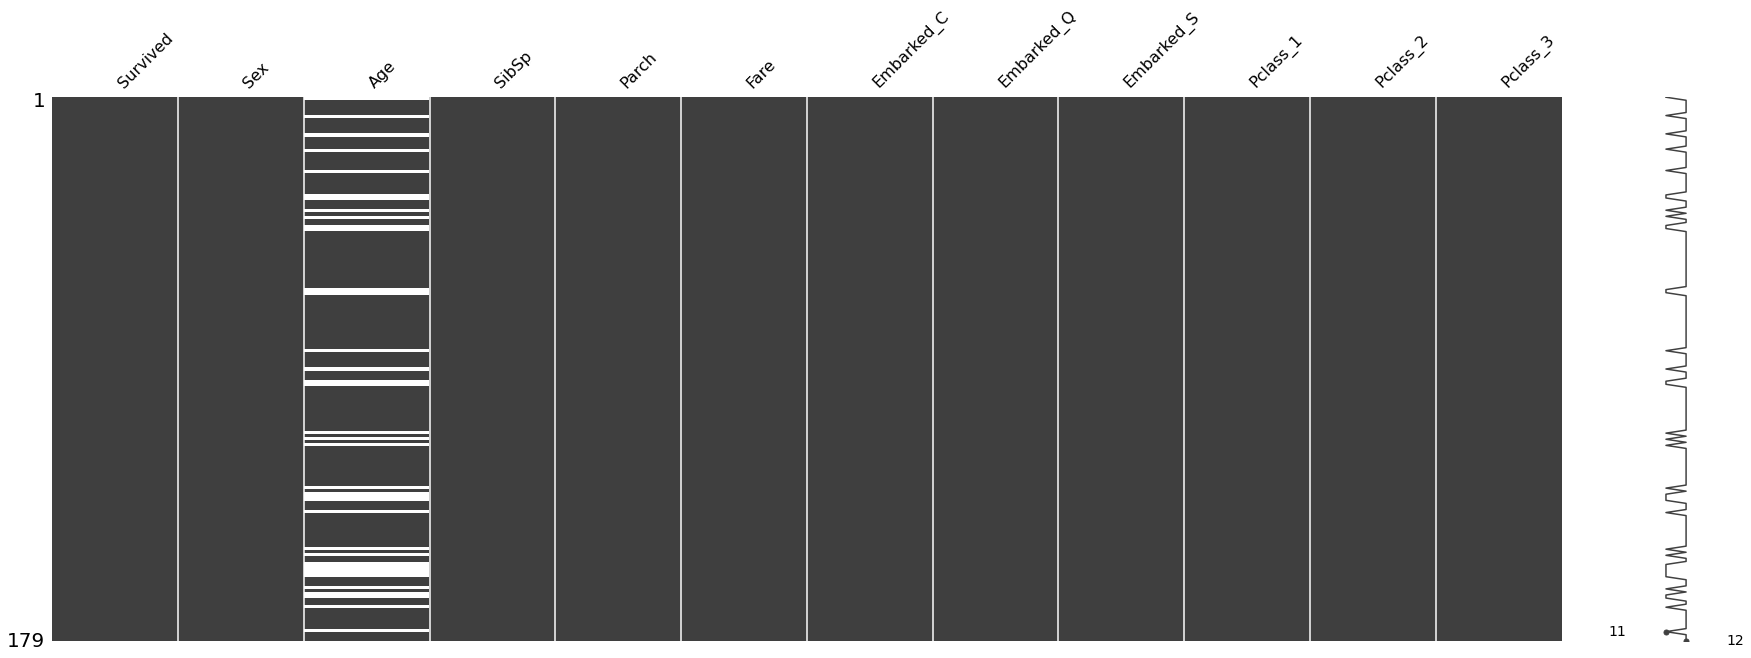

In [ ]:
missingno.matrix(val_data, figsize = (30,10))

**for test data**

*note that for the **test data**, you can't drop the missing value sample because kaggle expect the submitted submission file should maintain the original number of sample.*

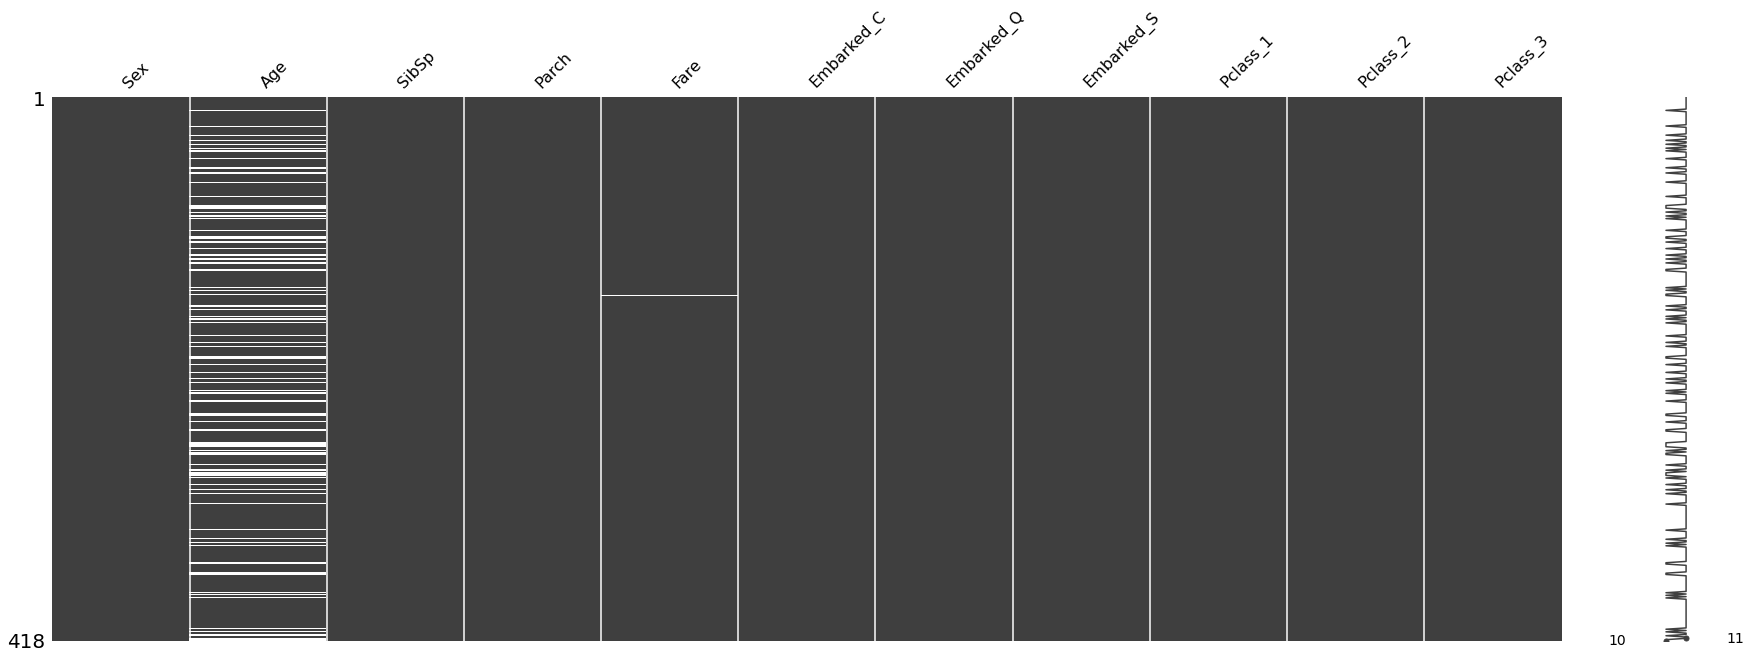

In [ ]:
missingno.matrix(test_data, figsize = (30,10))

#### step 11.2.1 : describe missing values numerically.

In [ ]:
for col in test_data.columns:
	n_miss = test_data[col].isnull().sum()
	perc = (n_miss / len(test_data)) * 100
	print(f'col : {col} | Missing samples : {n_miss} | Missing perc : {perc}%')

col : Sex | Missing samples : 0 | Missing perc : 0.0%
col : Age | Missing samples : 86 | Missing perc : 20.574162679425836%
col : SibSp | Missing samples : 0 | Missing perc : 0.0%
col : Parch | Missing samples : 0 | Missing perc : 0.0%
col : Fare | Missing samples : 1 | Missing perc : 0.23923444976076555%
col : Embarked_C | Missing samples : 0 | Missing perc : 0.0%
col : Embarked_Q | Missing samples : 0 | Missing perc : 0.0%
col : Embarked_S | Missing samples : 0 | Missing perc : 0.0%
col : Pclass_1 | Missing samples : 0 | Missing perc : 0.0%
col : Pclass_2 | Missing samples : 0 | Missing perc : 0.0%
col : Pclass_3 | Missing samples : 0 | Missing perc : 0.0%


##### 11.2.1.1 : deal with missing values (optional)

This is optional because some algorithm can handle missing values automatically. For example, LightGBM by specifying use_missing=false.

In [ ]:
from tqdm.notebook import tqdm

# step 1 : extract the column name in the test set that contain missing values
train_data_missing_values_col_names = extract_missing_values_col_names(train_data)
val_data_missing_values_col_names = extract_missing_values_col_names(val_data)
test_data_missing_values_col_names = extract_missing_values_col_names(test_data)
print(train_data_missing_values_col_names)
print(val_data_missing_values_col_names)
print(test_data_missing_values_col_names)

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

['Age']
['Age']
['Age', 'Fare']


##### option 1 : impute with mean or median values

for train data

In [ ]:
for col_names in train_data_missing_values_col_names:
  train_data[col_names].fillna(int(train_data[col_names].mean()), inplace=True)

for val data

In [ ]:
for col_names in val_data_missing_values_col_names:
  val_data[col_names].fillna(int(val_data[col_names].mean()), inplace=True)

for test data

In [ ]:
for col_names in test_data_missing_values_col_names:
  test_data[col_names].fillna(int(test_data[col_names].mean()), inplace=True)

##### option 2 : impute with mode (most frequent value)

##### option 3 : impute with knn classifier

In [ ]:
# from sklearn.impute import KNNImputer

# imputer = KNNImputer()
# train_data = pd.DataFrame(imputer.fit_transform(train_data), columns = test_data.columns)

##### option 4 : drop the sample

*note that for the **test data**, you can't drop the missing value sample because kaggle expect the submitted submission file should maintain the original number of sample.*

In [ ]:
# # step 1 : define feature name that has NA
# feature_name = 'Embarked'
# # step 2 : drop the sample (row) for train, val, test set
# train_data = train_data.dropna(subset=[feature_name])
# val_data = val_data.dropna(subset=[feature_name])
# test_data = test_data.dropna(subset=[feature_name])

### step 11.3 : visualize discrete features distribution

In [ ]:
print(sns.countplot(train_data.Parch).set_title("Train data - Parch"))

In [ ]:
print(sns.countplot(train_data.Embarked).set_title("Train data - Embarked"))

#### step 11.3.1 : deal with skewed discrete features

### step 11.4 : visualize continuous features distribution

In [ ]:
print(sns.displot(train_data.Fare))

#### step 11.4.1 : deal with skewed continuous features

#### option 1 : log transformation

In [ ]:
train_data['Fare'] = np.log(train_data['Fare'] + 1)
train_data['Fare'].skew()

In [ ]:
print(sns.displot(train_data.Fare))

### step 11.5 : visualize target class distribution

Text(0.5, 1.0, 'train data')


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


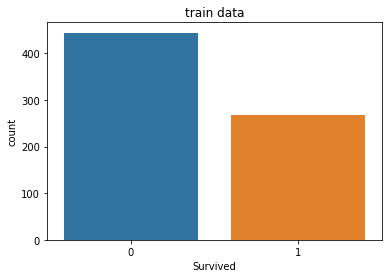

In [ ]:
print(sns.countplot(train_data.Survived).set_title("train data"))

#### step 11.5.1 : deal with imblance class

**Oversampling** or **undersampling** techniques below doesn't guarantee for the model to perform better on minority class. Read more [here](https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis).

#### option 1 : oversampling


In [ ]:
# from imblearn.over_sampling import SMOTE
# oversample = SMOTE()
# X, y = oversample.fit_resample(train_data.drop(columns= ['Survived']), train_data['Survived'])

In [ ]:
# X_df = pd.DataFrame(X, columns=train_data.drop(columns = ['Survived']).columns)
# y_df = pd.DataFrame(y, columns=['Survived'])

In [ ]:
# # concatenate
# X_df['Survived'] = y_df['Survived']
# train_data_upsample = X_df

#### option 2 : undersampling

In [ ]:
## add downsampling script

In [ ]:
## visualize after performing up or down sampling
# print(sns.countplot(train_data_upsample.Survived).set_title("train data"))

### 11.6 : visualize features correlation 

In this case, we are using `Pearson Correlation Matrix`. The `pearson correlation` measures the strength of the linear relationship between two variables. It has a value between -1 to 1, with a value of -1 meaning a total negative linear correlation, 0 being no correlation, and + 1 meaning a total positive correlation. The value greater than 0.5 has high correlation with the corresponding "pair of feature". (reference : [link](https://www.sciencedirect.com/topics/computer-science/pearson-correlation#:~:text=The%20Pearson%20correlation%20measures%20the,meaning%20a%20total%20positive%20correlation.))

>   Good examples of positive and negative correlation, [here](https://www.quora.com/What-are-some-good-positive-and-negative-correlation-examples).






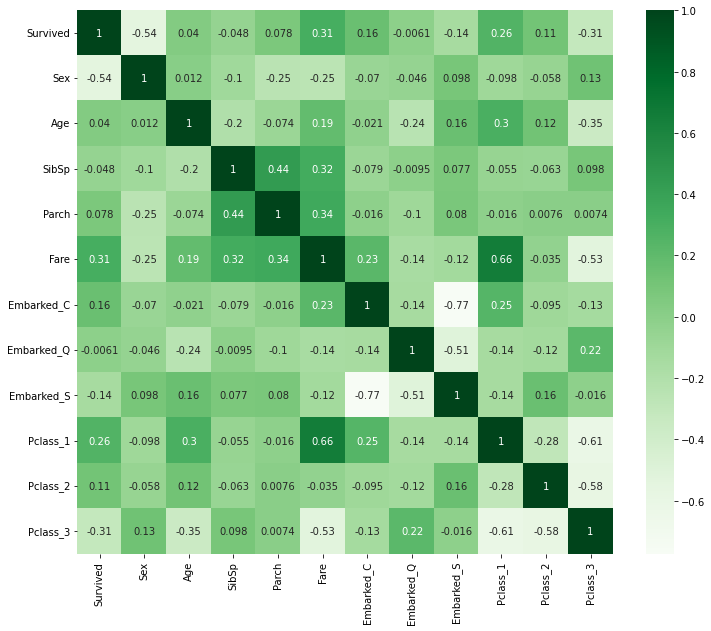

In [ ]:
plt.figure(figsize = (12, 10))
sns.heatmap(train_data.corr(), annot = True, cmap="Greens")
plt.show()

#### 11.6.1 : deal with multi-colinearity features

#### option 1 : drop the features `manually` 

In [ ]:
# train_data_upsample.drop(columns = ['Fare'], inplace = True)
# val_data.drop(columns = ['Fare'], inplace = True)
# test_data.drop(columns = ['Fare'], inplace = True)

#### option 2 : drop the features `automatically` by specifying correlation value threshold.

In [ ]:
# # step 1 : extract multi-colinearity features
# extracted_features, correlation_matrix = extract_multicolin_features(train_data, threshold = 0.4, plot = False)

# # step 2 : rank the extracted features based on the correlation with target value
# ranked_features = abs(correlation_matrix['Survived'][extracted_features])
# ranked_features = ranked_features.sort_values(ascending = False)

# # step 3 : remove all of the extracted features except the top feature
# top_feature = ranked_features.keys()[0]
# features_to_be_removed = list(ranked_features.drop(top_feature).keys())

# train_data.drop(columns = features_to_be_removed, inplace = True)
# val_data.drop(columns = features_to_be_removed, inplace = True)
# test_data.drop(columns = features_to_be_removed, inplace = True)

## step 12 : data modelling

### Regressor model

#### option 1 : linear regression (baseline) (optional)

In [ ]:
## add linear regression

#### option 2 : Gradient Boosting Regressor

### Classifier model

### option 1 : Logistic Regression (baseline) (optional)

In [ ]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import LogisticRegression

# # step 1 : construct the pipeline
# pipe = Pipeline([('scaler', StandardScaler()),
#                  ('clf', LogisticRegression())])

# # step 2 : specify the model param to explore
# param_grid = [{'clf__C': [1, 10, 100, 1000]}]
# gs_logistic_regression = GridSearchCV(pipe, param_grid, cv=5)

# # step 3 : train the model
# gs_logistic_regression.fit(train_data.drop(columns='Survived'), train_data['Survived'])

# print(f"rfcModel.best_params = {gs_logistic_regression.best_params_}")

In [ ]:
# # step 4 : evaluate the model on validation data
# evaluation_data_log = eval_train_test(gs_logistic_regression.best_estimator_, 
#                                       train_data_upsample.drop(columns='Survived'), 
#                                       val_data.drop(columns='Survived'), 
#                                       train_data['Survived'], 
#                                       val_data['Survived'],)
# print(evaluation_data_log)

### Option 2 : Catboost 

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from catboost import CatBoostClassifier

pipe = Pipeline([('poly', PolynomialFeatures(1)), 
                  ('scaler', StandardScaler()), 
                  ('cbr', CatBoostClassifier(silent=True, random_seed=13, loss_function='Logloss'))])

param_grid = {'cbr__iterations': [50, 100, 250], 
             'cbr__depth': [4, 5, 7, 8, 9],}

gs_catboost = GridSearchCV(pipe, param_grid, cv=5)
gs_catboost.fit(train_data.drop(columns='Survived'), train_data['Survived'])

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('poly', PolynomialFeatures(degree=1)),
                                       ('scaler', StandardScaler()),
                                       ('cbr',
                                        <catboost.core.CatBoostClassifier object at 0x7f470f0cda10>)]),
             param_grid={'cbr__depth': [4, 5, 7, 8, 9],
                         'cbr__iterations': [50, 100, 250]})

In [ ]:
# step 3 : evaluate the scores on train and test set
evaluation_data_log = eval_train_test(gs_catboost.best_estimator_, 
                                      train_data.drop(columns='Survived'), 
                                      val_data.drop(columns='Survived'), 
                                      train_data['Survived'], 
                                      val_data['Survived'],)

print(evaluation_data_log)

       precision    recall        f1 support
train   0.890264  0.847654  0.861723    None
test    0.786277  0.771171  0.775955    None


## step 13 : visualize features importance

The function used below to visualize `features importance` is copied from Daniel Bourke notebook [here](https://github.com/mrdbourke/your-first-kaggle-submission/blob/master/kaggle-titanic-dataset-example-submission-workflow.ipynb).

In [ ]:
def feature_importance(model, data):
    """
    Function to show which features are most important in the model.
    ::param_model:: Which model to use?
    ::param_data:: What data to use?
    """
    fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': data.columns})
    fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
    _ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
    return fea_imp
    #plt.savefig('catboost_feature_importance.png') 

## step 14 : prepare for submission

In [ ]:
# step 1 : intiliazie best model with the corresponding hyper-params
best_model = gs_catboost.best_estimator_

predictions = best_model.predict(test_data)

# # step 4 : retrieve the prediction probability (Optional)
# total_probs = best_model.predict_proba(test_data)
# probs = [total_probs[i, pred] for i, pred in enumerate(predictions)]

# step 5 : load the submission file
submission_path = '/content/gender_submission.csv' 
submission = pd.read_csv(submission_path)

# step 6 : fill the target with the prediction probability
submission['Survived'] = predictions

# step 7 : save the submission file
save_path = '/content/prediction7.csv'
submission.to_csv(save_path, index = False)

In [ ]:
submission.head(5)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


# Conclusion

It turns out that high scores in the validation set do not guarantee high scores in the test set. 